In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression
import xml.etree.ElementTree as ET
import time
import json
import tarfile
import gzip
import os

from data_preprocessing import * 
from imdb_ratings_scraper import *
import load_functions as lf


# Load data

## Movie Summaries

In [5]:
data_folder = './data/MovieSummaries/'
(movie_metadata, character_metadata, name_clusters, plot_summaries, test_data) = \
    lf.load_movie_summaries(data_folder)

# add release year (float) to movie_metadata, extracting it from release_date
movie_metadata['release_year'] = movie_metadata['release_date'].apply(lambda x: lf.extract_year(x))
# add lowecase title to movie_metadata
movie_metadata['lowercase_title'] = movie_metadata['movie_name'].str.lower()

# add release year (float) to character_metadata, extracting it from release_date
character_metadata['release_year'] = character_metadata['release_date'].apply(lambda x: lf.extract_year(x))
# add actor birth year (float) to character_metadata, extracting it from actor_birth_date
character_metadata['actor_birth_year'] = character_metadata['actor_birth_date'].apply(lambda x: lf.extract_year(x))

Metadata for 81 741 movies, extracted from the Noverber 4, 2012 dump of Freebase:
1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)
10. Movie release year
11. Lowercase title

In [6]:
movie_metadata.head()

,wiki_movie_id,free_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres,release_year,lowercase_title
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,ghosts of mars
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000.0,getting away with murder: the jonbenét ramsey ...
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988.0,brun bitter
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987.0,white of the eye
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983.0,a woman in flames


Metadata for 450 669 characters aligned to the movies above, extracted from the Noverber 4, 2012 dump of Freebase:
1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID
14. Release year
15. Actor birth year

In [7]:
character_metadata.head()

,wiki_movie_id,free_movie_id,release_date,character_name,actor_birth_date,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,free_character_actor_map_id,free_character_id,free_actor_id,release_year,actor_birth_year
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001.0,1958.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001.0,1974.0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001.0,1969.0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001.0,1967.0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001.0,1977.0


Plot summaries of 42 303 movies extracted from the November 2, 2012 dump of English-language Wikipedia.
Each line contains the Wikipedia movie ID (which indexes into movie_metadata) followed by the summary.

In [8]:
plot_summaries.head()

,wiki_movie_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


# Basic features analysis

## Undestanding the dataset

In [9]:
print('number of nan values in movie_metadata:')
print(movie_metadata.isna().sum())
print('\nnumber of rows in movie_metadata:',movie_metadata.shape[0])

number of nan values in movie_metadata:
wiki_movie_id             0
free_movie_id             0
movie_name                0
release_date           6902
box_office_revenue    73340
runtime               20450
languages                 0
countries                 0
genres                    0
release_year           6902
lowercase_title           0
dtype: int64

number of rows in movie_metadata: 81741


In [10]:
print('number of nan values in character_metadata:')
print(character_metadata.isna().sum())
print('\nnumber of character_metadata rows:', character_metadata.shape[0])

number of nan values in character_metadata:
wiki_movie_id                       0
free_movie_id                       0
release_date                     9995
character_name                 257875
actor_birth_date               106145
actor_gender                    45609
actor_height                   295845
actor_ethnicity                344611
actor_name                       1228
actor_age                      158113
free_character_actor_map_id         0
free_character_id              257865
free_actor_id                     815
release_year                     9995
actor_birth_year               106156
dtype: int64

number of character_metadata rows: 450669


In [11]:
print('unique values of freebase movie ID in character_metadata:',
      len(character_metadata['free_movie_id'].unique()))
print('freebase movie ID in character_metadata:',
      len(character_metadata['free_movie_id']))
print('number of movie ID in character_metadata, which appear in movie_metadata:',
      sum(movie_metadata['free_movie_id'].isin(character_metadata['free_movie_id'].unique())))

unique values of freebase movie ID in character_metadata: 64330
freebase movie ID in character_metadata: 450669
number of movie ID in character_metadata, which appear in movie_metadata: 64330


Each movie in character_metadata appears in movie_metadata

In [12]:
print('unique values of freebase character ID in character_metadata (number of characters):',
      len(character_metadata['free_character_id'].unique()))
print('unique values of freebase actor ID in character_metadata (number of actors):',
      len(character_metadata['free_actor_id'].unique()))
print('unique values of actor ethnicity in character_metadata (number of ethnicities):',
      len(character_metadata['actor_ethnicity'].unique()))

unique values of freebase character ID in character_metadata (number of characters): 183436
unique values of freebase actor ID in character_metadata (number of actors): 135761
unique values of actor ethnicity in character_metadata (number of ethnicities): 480


## Plot data

### Movies metadata

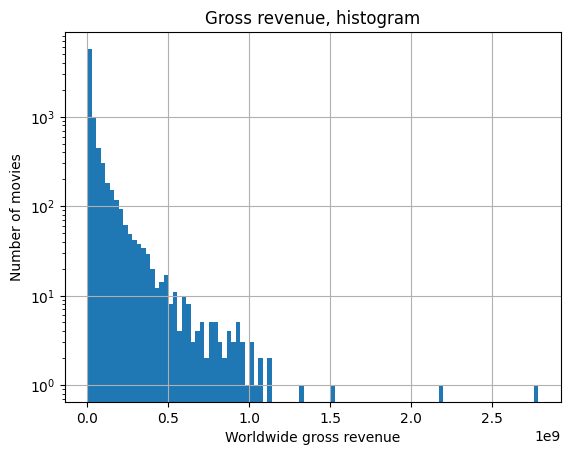

In [13]:
# gross revenue histogram
movie_metadata['box_office_revenue'].dropna().hist(bins = 100, log=True)
plt.xlabel('Worldwide gross revenue')
plt.ylabel('Number of movies')
plt.title('Gross revenue, histogram');

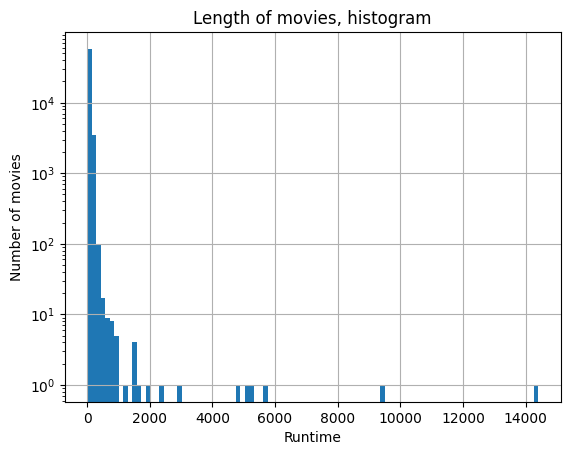

In [14]:
# length of movies histogram.
# We dropped movies with a length >= 1079280, as we observed errors in the dataset
movie_metadata[movie_metadata['runtime'] < 1079280].runtime.dropna().hist(bins = 100, log=True)
plt.xlabel('Runtime')
plt.ylabel('Number of movies')
plt.title('Length of movies, histogram');

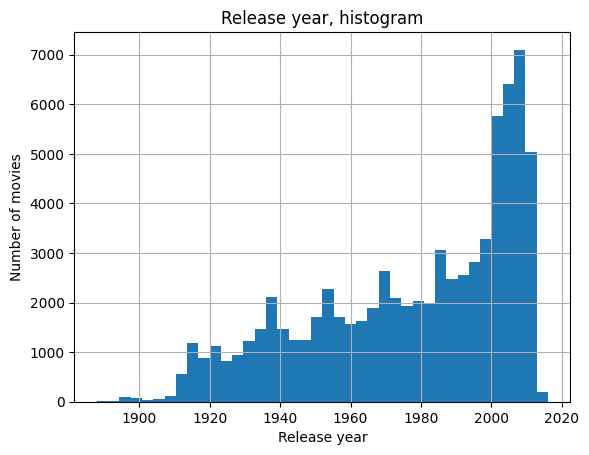

In [15]:
# release year histogram. We dropped movies with a release year <= 1011,
# We dropped movies with a release year <= 1011, as we observed errors in the dataset
movie_metadata[movie_metadata['release_year'] > 1011].release_year.dropna().hist(bins = 40, log=False)
plt.xlabel('Release year')
plt.ylabel('Number of movies')
plt.title('Release year, histogram');

### Characters metadata

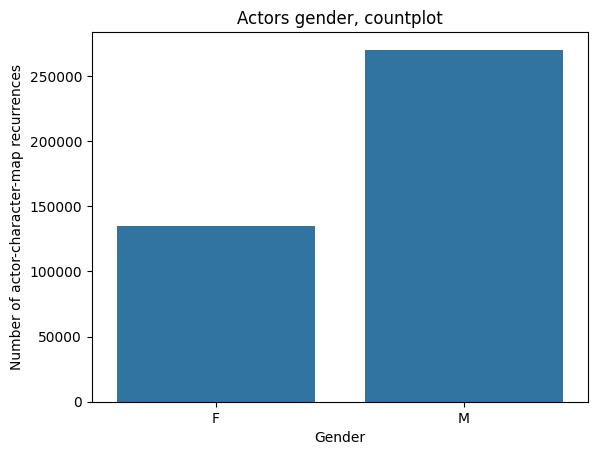

In [16]:
# actor gender countplot
sns.countplot(data=character_metadata, x="actor_gender");
plt.title('Actors gender, countplot')
plt.xlabel('Gender')
plt.ylabel('Number of actor-character-map recurrences');

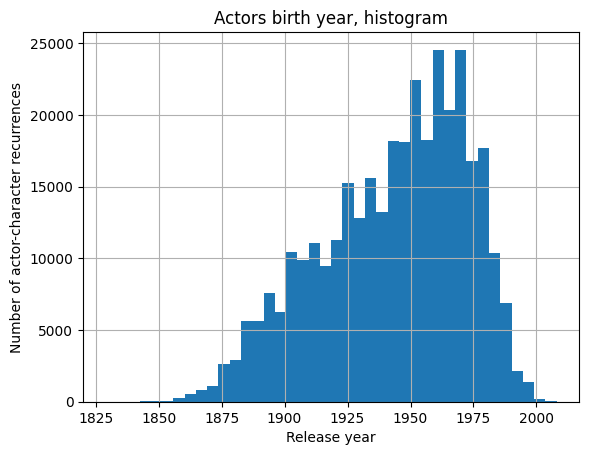

In [17]:
# actor birth year, histogram
# We dropped actors with a birth year <= 1828 or >= 2009, as we observed errors in the dataset
character_metadata[(character_metadata['actor_birth_year'] > 1828) * (character_metadata['actor_birth_year'] < 2009)].actor_birth_year.dropna().hist(bins = 40, log=False)
plt.xlabel('Release year')
plt.ylabel('Number of actor-character recurrences')
plt.title('Actors birth year, histogram');

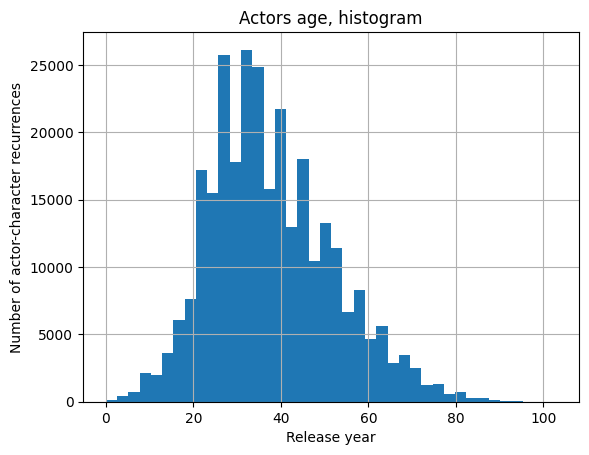

In [18]:
# actor age histogram
# We dropped actors with an age < 0, as we observed errors in the dataset
character_metadata[character_metadata['actor_age'] >= 0].actor_age.dropna().hist(bins = 40, log=False)
plt.xlabel('Release year')
plt.ylabel('Number of actor-character recurrences')
plt.title('Actors age, histogram');

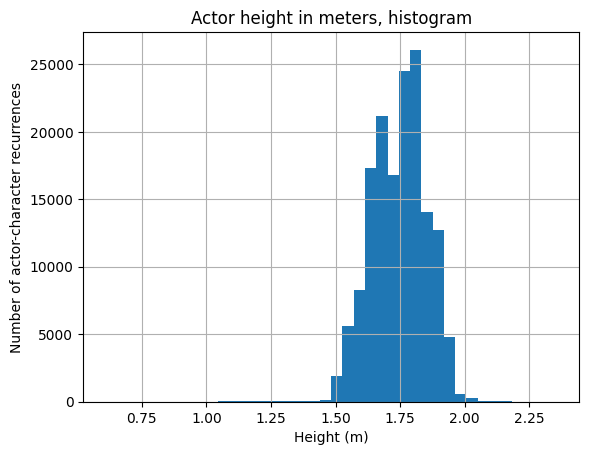

In [19]:
# actor height histogram
# We dropped actors with a height >= 3, as we observed errors in the dataset
character_metadata[character_metadata['actor_height'] < 3].actor_height.dropna().hist(bins = 40, log=False)
plt.xlabel('Height (m)')
plt.ylabel('Number of actor-character recurrences')
plt.title('Actor height in meters, histogram');

# Plot evolution and similarity


In [20]:
from similarity_and_evolution import preprocess_text, cosine_similarity

plot_similarity = plot_summaries
plot_evolution = plot_summaries
plot_similarity['count_words'] = plot_similarity.apply(lambda x: len(str(x['plot']).split()), axis=1)

# Drop plots with less than 200 words
plot_similarity.drop(plot_similarity[plot_similarity['count_words'] < 200].index, inplace= True)

# Preprocess the synopses
# The Hunger Games
preprocessed_synopsis1 = preprocess_text(plot_similarity.query("wiki_movie_id == 31186339").iloc[0]['plot'])

# Fast and Furious: Tokyo Drift
preprocessed_synopsis2 = preprocess_text(plot_similarity.query("wiki_movie_id == 2913859").iloc[0]['plot'])

# Harry Potter: Deathly Hallows Part I
preprocessed_synopsis3 = preprocess_text(plot_similarity.query("wiki_movie_id == 9834441").iloc[0]['plot'])

# Mamma mia
preprocessed_synopsis4 = preprocess_text(plot_similarity.query("wiki_movie_id == 8425661").iloc[0]['plot'])

Compute cosine similarity between preprocessed plots

In [21]:
similarity_1 = cosine_similarity(preprocessed_synopsis1, preprocessed_synopsis2)
similarity_2 = cosine_similarity(preprocessed_synopsis1, preprocessed_synopsis3)
similarity_3 = cosine_similarity(preprocessed_synopsis1, preprocessed_synopsis4)
similarity_4 = cosine_similarity(preprocessed_synopsis3, preprocessed_synopsis4)

### Cosine similarity interpretation and validation
If cosine similarity is equal to 1 means both plots are identical. On the other side, if cosine similarity is equal to 0 means the plots have nothing in common.

Overviewing the below similarities, it makes sense that "The Hunger Games" is more similar to a film such as "Harry Potter: Deathly Hallows Part 1" for more common actions such as "kill", "reveal" and "take" than to Fast&Furious and Mamma Mia. This actions may appear also in the latter movies but with less relevance.

And unusual phenomena is observed when comparing Harry Potter to Mamma Mia. Using the user's experience, one can argue these films are not very much alike. Investigating the issue further, we discover that this high value on similarity is due to one of the main protagonist for both films are called Harry.

Filtering people's name might be necessary to refine the algorithm.

In [22]:
print(f"Cosine Similarity The Hunger Games - F&F:Tokyo Drift: {similarity_1}")
print(f"Cosine Similarity The Hunger Games - HP: Deathly Hallows P1: {similarity_2}")
print(f"Cosine Similarity The Hunger Games - Mamma mia: {similarity_3}")
print(f"Cosine Similarity HP: Death Hollows P1 - Mamma mia: {similarity_4}")

Cosine Similarity The Hunger Games - F&F:Tokyo Drift: 0.029112649379961022
Cosine Similarity The Hunger Games - HP: Deathly Hallows P1: 0.0582765471839679
Cosine Similarity The Hunger Games - Mamma mia: 0.029958426421823198
Cosine Similarity HP: Death Hollows P1 - Mamma mia: 0.033301144786951474


### Similarity computation by year
We are interested on how much similar are movies released on the same year are alike

In [23]:
plot_similarity_enriched = pd.merge(plot_similarity, movie_metadata[['movie_name','release_year','wiki_movie_id']], on="wiki_movie_id",how='left')
plot_similarity_enriched.head()

,wiki_movie_id,plot,count_words,movie_name,release_year
0,31186339,The nation of Panem consists of a wealthy Capi...,778,The Hunger Games,2012.0
1,20663735,Poovalli Induchoodan is sentenced for six yea...,496,Narasimham,2000.0
2,2231378,"The Lemon Drop Kid , a New York City swindler,...",849,The Lemon Drop Kid,1951.0
3,595909,Seventh-day Adventist Church pastor Michael Ch...,397,A Cry in the Dark,1988.0
4,5272176,The president is on his way to give a speech. ...,344,End Game,2006.0


In [24]:
#similarity_by_year = plot_similarity_enriched.groupby('release_year')
#for year, group in similarity_by_year:
#    for idx, row in group.iterrows():
#        preprocessed_text = preprocess_text(row['plot'])
#        print(preprocessed_text)

### Emotional arc

An interesting aspect of a movie is its emotional arc. We give a sentiment value to each sentence in the plot summary and then interpret the sequence of sentiment values of the sentences as the movie's emotional arc.

In [25]:
from similarity_and_evolution import tokenize_per_sentence
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# The Hunger Games, tokenized per sentence
plot_per_sentence1 = tokenize_per_sentence(plot_evolution.query("wiki_movie_id == 31186339").iloc[0]['plot'])
# Fast and Furious: Tokyo Drift, tokenized per sentence
plot_per_sentence2 = tokenize_per_sentence(plot_evolution.query("wiki_movie_id == 2913859").iloc[0]['plot'])

In [26]:
analyzer = SentimentIntensityAnalyzer()
"""
    This function computes the sentiment value of each sentence in the plot, and returns all of them as a list.
"""
def compute_sentiment_sequence(plot_sentences):
    sentiment_sequence = []
    for sentence in plot_sentences:
        sentiment_sequence.append(analyzer.polarity_scores(sentence)['compound'])
    return sentiment_sequence

Text(0, 0.5, 'sentiment value')

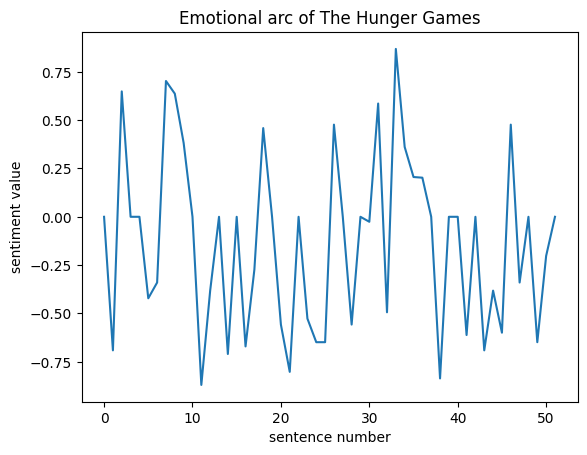

In [49]:
# plot the sentiment value sequence, i.e emotional arc, of the Hunger Games
emotional_arc1 = compute_sentiment_sequence(plot_per_sentence1)
plt.plot(emotional_arc1)
plt.title("Emotional arc of The Hunger Games")
plt.xlabel("sentence number")
plt.ylabel("sentiment value")

To take the average over different emotional arcs of movies, there is one problem. They are of different length. We circumvent this problem by normalizing all emotional arcs to one length, namely the average length of all emotional arcs.

Text(0, 0.5, 'sentiment value')

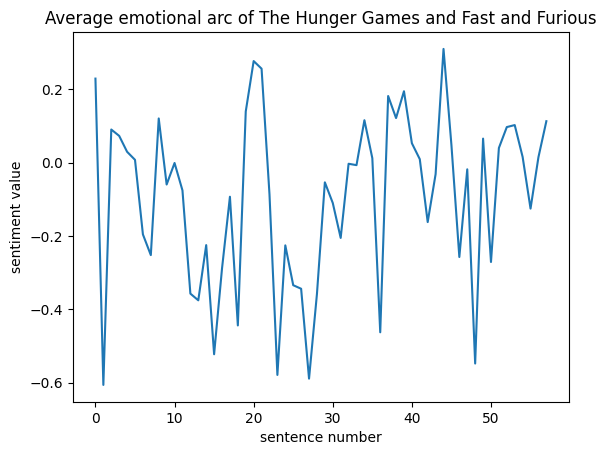

In [50]:
from scipy.interpolate import interp1d
import statistics
# compute emotional arc of Fast and Furious
emotional_arc2 = compute_sentiment_sequence(plot_per_sentence2)

# compute the length to which we normalize both sequences as the average of the two lengths
normalized_length = round(sum([len(emotional_arc1), len(emotional_arc2)])/2)

# normalize both sequences to this lenght using interpolation
interpolate1 = interp1d(np.linspace(0, 1, len(emotional_arc1)), emotional_arc1)
interpolate2 = interp1d(np.linspace(0, 1, len(emotional_arc2)), emotional_arc2)
emotional_arc2_norm = interpolate2(np.linspace(0, 1, normalized_length))
emotional_arc1_norm = interpolate1(np.linspace(0, 1, normalized_length))

# compute average emotional arc over these two movies
average_emotional_arc = np.mean([emotional_arc1_norm, emotional_arc2_norm], axis=0)
plt.plot(average_emotional_arc)
plt.title("Average emotional arc of The Hunger Games and Fast and Furious")
plt.xlabel("sentence number")
plt.ylabel("sentiment value")

As we can see that the emotional arcs is not smooth at all, we will still have to apply some smoothing to them to make them more interpretable.

## Regression ratings change over the years

In [20]:
# load merged dataset with imdb ids and movie metadata
# loading merged in order to not have two huge dataset in memory
res = pd.read_csv('data/movies_imdb_ids.csv')

In [21]:
res['release date'] = pd.to_datetime(res['release date'], format='%Y-%m-%d',  errors = 'coerce') # convert to datetime format
res = res.loc[res['release date']  > datetime(2004, 1, 1)].copy()  # only consider dates after 2004 (before imdb didn't exist)
res = res.loc[res['box office revenue'].notna()].copy() # remove ones without box office revenue
res.reset_index(inplace=True, drop=True)
res = res.loc[:, ~res.columns.str.contains('^Unnamed')]  # dropping unnamed columns
res.head(1)

,Wikipedia movie ID,Freebase movie ID,name,release date,box office revenue,runtime,languages,countries,genres_x,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres_y
0,12621957,/m/05pdd86,the sorcerer's apprentice,2010-07-08,215283742.0,111.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...",tt0048644,short,the sorcerer's apprentice,The Sorcerer's Apprentice,0,1955,\N,13,Short


The following cell scrapes the reviews after one and five years for a certain movie. It utilized https://archive.org/web/ which periodically takes a snapshot of the whole internet and allows to see how a website changes in time. 

In [17]:
# only run if want to scrape new data 
number_elements_to_scrape = len(res)

ratings_df = pd.DataFrame()

for index, row in res.iloc[:number_elements_to_scrape].iterrows():

    print(f"{index}/{number_elements_to_scrape} scraped -- Now scraping {row['tconst']}", end = '\r')

    try: 
        dates, ratings, num_voters = scraper_review_next_and_five_years(row['tconst'], row['release date'])
        ratings.extend(num_voters)
        df = pd.DataFrame([ratings], columns=['after_one_year_rating', 'after_five_year_rating', 'one_year_num_voters', 'five_year_num_voters',], index = [row['tconst']])
        ratings_df = pd.concat([df, ratings_df],  sort=False)
        # df = pd.DataFrame([num_voters], columns=['first_date', 'second_date'], index = [row['tconst'] ])
        # num_voters_df = pd.concat([df, num_voters_df],  sort=False)
    except Exception as e: 
        print(f"Exception {e}")  # handling all excpetion in order to not sto pscraping process

# print(result_df.head())
ratings_df.to_csv('data/imbd_ratings.csv') # save scraped for future use

In [22]:
ratings_df = pd.read_csv('data/imbd_ratings.csv') 
ratings_df = ratings_df.set_index(ratings_df.iloc[:, 0])
ratings_df = ratings_df.loc[:, ~ratings_df.columns.str.contains('^Unnamed')] 

ratings_metadata = res.merge(ratings_df, how ='right', left_on='tconst', right_index=True)
ratings_metadata.head(1)

,Wikipedia movie ID,Freebase movie ID,name,release date,box office revenue,runtime,languages,countries,genres_x,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres_y,first_date,second_date
NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,tt0383460_ratings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.3,7.8


In [19]:
ratings_metadata['genres_x']

NaN    NaN
NaN    NaN
NaN    NaN
NaN    NaN
NaN    NaN
      ... 
NaN    NaN
NaN    NaN
NaN    NaN
NaN    NaN
NaN    NaN
Name: genres_x, Length: 114, dtype: object

In [88]:
def get_first_value_from_dictionary(row, value):
    l = list(json.loads(row[value]).values())
    if len(l) > 0: 
        genres = l[0]
    else: 
        genres = ''
    return genres

def count_dictionary(row, value): 
    return len(json.loads(row[value]).keys())

# extracting values from dictionaries
ratings_metadata["genre"] = ratings_metadata.apply(lambda row: get_first_value_from_dictionary(row, 'genres_x'), axis=1)
ratings_metadata["language"] = ratings_metadata.apply(lambda row: get_first_value_from_dictionary(row, 'languages'), axis=1)
ratings_metadata["country"] = ratings_metadata.apply(lambda row: get_first_value_from_dictionary(row, 'countries'), axis=1)
ratings_metadata['year'] = pd.DatetimeIndex(ratings_metadata['release date']).year  # extracting year

ratings_metadata["n_genre"] = ratings_metadata.apply(lambda row: count_dictionary(row, 'genres_x'), axis=1)
ratings_metadata["n_language"] = ratings_metadata.apply(lambda row: count_dictionary(row, 'languages'), axis=1)
ratings_metadata["n_country"] = ratings_metadata.apply(lambda row: count_dictionary(row, 'countries'), axis=1)

In [90]:
ratings_metadata.columns

Index(['Wikipedia movie ID', 'Freebase movie ID', 'name', 'release date',
       'box office revenue', 'runtime', 'languages', 'countries', 'genres_x',
       'tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'endYear', 'runtimeMinutes', 'genres_y',
       'after_one_year_rating', 'after_five_year_rating',
       'one_year_num_voters', 'five_year_num_voters', 'genre', 'language',
       'country', 'year', 'n_genre', 'n_language', 'n_country'],
      dtype='object')

In [91]:
# variable we'll try to predict
y = (ratings_metadata.after_five_year_rating - ratings_metadata.after_one_year_rating) * (ratings_metadata.five_year_num_voters - ratings_metadata.one_year_num_voters) # TODO: adjust by the number of voters
df_clean = ratings_metadata.drop(['Wikipedia movie ID', 'Freebase movie ID',
       'name', 'release date', 'languages', 'isAdult', 
       'countries', 'genres_x', 'tconst', 'titleType', 'primaryTitle',
       'originalTitle', 'startYear', 'endYear', 'runtimeMinutes',
       'genres_y', 'after_one_year_rating', 'after_five_year_rating',
       'one_year_num_voters', 'five_year_num_voters'], axis = 1).copy(deep = True)

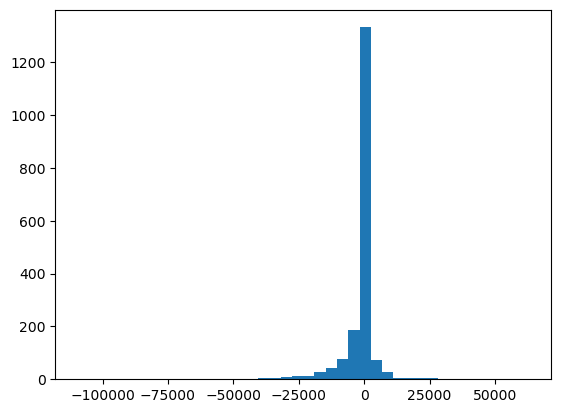

In [92]:
plt.hist(y, bins = 40)
plt.show()

In [93]:
X = pd.get_dummies(df_clean[['genre']])
# Drop column B as it is now encoded
X=(X-X.min())/(X.max() - X.min())
X.fillna(0, inplace=True)

reg = LinearRegression().fit(X, y)
sorted(zip(reg.coef_,X.columns))[:5], sorted(zip(reg.coef_,X.columns))[-5:] # find which coefficient are more important


([(1.6510037834911568e+16, 'genre_Superhero movie'),
  (1.6510037834922528e+16, 'genre_Supernatural'),
  (1.6510037834941582e+16, 'genre_Tragedy'),
  (1.65100378349416e+16, 'genre_Adult'),
  (1.6510037834943044e+16, 'genre_Comedy of Errors')],
 [(1.6510037834955798e+16, 'genre_Inspirational Drama'),
  (1.6510037834956352e+16, 'genre_Musical comedy'),
  (1.651003783495722e+16, 'genre_Remake'),
  (1.6510037834959392e+16, 'genre_Swashbuckler films'),
  (1.6510037834961564e+16, 'genre_Screwball comedy')])

In [84]:
ratings_metadata.difference = y

/tmp/ipykernel_27235/3273029692.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ratings_metadata.difference = y


In [109]:
import statsmodels.api as sm

y = (ratings_metadata.after_five_year_rating - ratings_metadata.after_one_year_rating) #* (ratings_metadata.five_year_num_voters - ratings_metadata.one_year_num_voters)
y = (y > 0).astype(int)
X = ratings_metadata[['box office revenue', 'year', 'runtime', 'n_language', 'n_genre', 'one_year_num_voters']]
X.fillna(0, inplace=True)
X = sm.add_constant(X)

model = sm.Logit(y, X)
results = model.fit()
print(results.summary())


Optimization terminated successfully.
         Current function value: 0.626360
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1844
Model:                          Logit   Df Residuals:                     1837
Method:                           MLE   Df Model:                            6
Date:                Thu, 07 Dec 2023   Pseudo R-squ.:                 0.05262
Time:                        17:35:22   Log-Likelihood:                -1155.0
converged:                       True   LL-Null:                       -1219.2
Covariance Type:            nonrobust   LLR p-value:                 2.941e-25
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -147.0482     43.931     -3.347      0.001    -233.150     -60.946
bo

/home/stefano/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Logistic regression on having or not better reviews after five years. Features that have negative influence: number of languages, nuber of genre, and number of voters after one year. This sugests that the wider the audience, the more commercialized a certain movie is the worst it's reviews are gonna be in 5 years. <br>
In recent years we're making movies that age better. <br>
On average movies have a worst rating after five years. 

In [110]:
y = (ratings_metadata.after_five_year_rating - ratings_metadata.after_one_year_rating) * (ratings_metadata.five_year_num_voters - ratings_metadata.one_year_num_voters)
y = (y > 0).astype(int)
X = ratings_metadata[['box office revenue', 'year', 'runtime', 'n_language', 'n_genre']]
X.fillna(0, inplace=True)
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     8.364
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           7.84e-08
Time:                        17:35:56   Log-Likelihood:                -1254.6
No. Observations:                1844   AIC:                             2521.
Df Residuals:                    1838   BIC:                             2554.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -18.3342      9

/home/stefano/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Here we regress on the difference in ratings weighted by the number of voters, the results are similar to before

## Most important features over time

In [24]:
res = pd.read_csv('data/movies_imdb_ids.csv')

In [25]:
res['release date'] = pd.to_datetime(res['release date'], format='%Y-%m-%d') # convert to datetime format
res = res.loc[res['release date']  > datetime(2004, 1, 1)].copy()  # only consider dates after 2004 (before imdb didn't exist)
res = res.loc[res['box office revenue'].notna()].copy() # remove ones without box office revenue
res.reset_index(inplace=True, drop=True)
res = res.loc[:, ~res.columns.str.contains('^Unnamed')]  # dropping unnamed columns
res.fillna(res.mean(), inplace=True)


/tmp/ipykernel_27235/1811638890.py:6: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  res.fillna(res.mean(), inplace=True)
/tmp/ipykernel_27235/1811638890.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  res.fillna(res.mean(), inplace=True)


In [28]:
from datetime import * 

days_range = 700

start_range = datetime(1920, 1, 1)
end_range = datetime(1920, 1, 1) + timedelta(days_range)
max_date = res['release date'].max()

res = res.loc[res['release date'] >= start_range].copy(deep = True)

while start_range < max_date: 
    res.loc[(res['release date'] >= start_range) & (res['release date'] < end_range), ('release date')]  = start_range
    start_range = end_range
    end_range = end_range + timedelta(days_range)

In [32]:
ratings_df = pd.read_csv('data/imbd_ratings.csv') 
ratings_df = ratings_df.set_index(ratings_df.iloc[:, 0])
ratings_df = ratings_df.loc[:, ~ratings_df.columns.str.contains('^Unnamed')] 

ratings_metadata = res.merge(ratings_df, how ='right', left_on='tconst', right_index=True)
ratings_metadata.columns

Index(['Wikipedia movie ID', 'Freebase movie ID', 'name', 'release date',
       'box office revenue', 'runtime', 'languages', 'countries', 'genres_x',
       'tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'endYear', 'runtimeMinutes', 'genres_y',
       'after_one_year_rating', 'after_five_year_rating',
       'one_year_num_voters', 'five_year_num_voters'],
      dtype='object')

In [114]:
import statsmodels.api as sm


y = ratings_metadata[['box office revenue']]
X = ratings_metadata[['runtime', 'isAdult', 'year', 'after_one_year_rating', 'n_language', 'n_genre', 'one_year_num_voters', ]]
X.fillna(0, inplace=True)
X = sm.add_constant(X)

model = sm.OLS(y, X.astype(float))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     box office revenue   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     77.13
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           3.22e-98
Time:                        17:50:39   Log-Likelihood:                -37135.
No. Observations:                1844   AIC:                         7.429e+04
Df Residuals:                    1836   BIC:                         7.433e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -8.666e+

/home/stefano/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [121]:
for name, group in ratings_metadata.groupby('release date'): 
    y = group[['box office revenue']]
    X = group[['runtime', 'isAdult', 'year', 'after_one_year_rating', 'n_language', 'n_genre', 'one_year_num_voters', ]].copy()
    X.fillna(0, inplace=True)
    X = sm.add_constant(X)

    model = sm.OLS(y, X.astype(float))
    results = model.fit()
    print(name)
    print(results.summary())
    print('\n\n\n')

2002-05-30 00:00:00
                            OLS Regression Results                            
Dep. Variable:     box office revenue   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     11.05
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           1.43e-07
Time:                        17:53:48   Log-Likelihood:                -1277.2
No. Observations:                  66   AIC:                             2566.
Df Residuals:                      60   BIC:                             2580.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
runtime   